In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import geopy
from geopy.distance import great_circle

In [2]:
# opening meta data of all gradients 1, 2, and 3
meta_data = pd.read_csv('sample_metadata.csv')
meta_df = meta_data[['SampleID', 'Cruise', 'Dataset', 'Datetime', 'Station', 'Latitude', 'Longitude', 'Depth']]
meta_df.columns = meta_df.columns.str.lower()

#resolved depth of 7 to 5, 41 to 40, 50 to 45, and 55 to 60
meta_df.loc[meta_df['depth'] == 7, 'depth'] = 5
meta_df.loc[meta_df['depth'] == 41, 'depth'] = 40
meta_df.loc[meta_df['depth'] == 50, 'depth'] = 45
meta_df.loc[meta_df['depth'] == 55, 'depth'] = 60

#creating merged df of Prochlorococcus and Synechococcus meta data and file with ecotypes
meta_df2 = meta_data[['SampleID', 'Cruise', 'Station', 'Datetime',
                   'Latitude', 'Longitude', 'Depth', 'Replicate']]

rel_abun = pd.read_csv('grad_relative_abundance.csv')

rel_abun2 = rel_abun[rel_abun.columns[~rel_abun.columns.isin(['Unnamed: 0','Transcripts','Reads', 'TPM'])]]
meta_abun2 = meta_df2.merge(rel_abun2)

# subsetting dataframes by genus
pro_meta_abun = meta_abun2.loc[(meta_abun2['Genus'] == 'Prochlorococcus') & (meta_abun2['RelAbundance'] >= 0.05)]
syn_meta_abun = meta_abun2.loc[(meta_abun2['Genus'] == 'Synechococcus') & (meta_abun2['RelAbundance'] >= 0.05)]

In [3]:
#subset meta dataframe to only gradient 3
g3_meta = meta_df.loc[meta_df['cruise'] == 'km1906']
g3_ecotype_pro = pro_meta_abun.loc[pro_meta_abun['Cruise'] == 'km1906']
g3_ecotype_syn = syn_meta_abun.loc[syn_meta_abun['Cruise'] == 'km1906']

In [4]:
# opening underway g3 file
g3_underway = pd.read_feather('g3_fcm.feather')
# subsetting dataframe
g3_underway_fcm = g3_underway[['filename', 'pop', 'norm.scatter', 'norm.red', 'norm.orange', 'date', 'lat', 'lon', 'depth']]
g3_pro_underway_fcm = g3_underway_fcm.loc[g3_underway_fcm['pop'] == 'prochloro']
g3_syn_underway_fcm = g3_underway_fcm.loc[g3_underway_fcm['pop'] == 'synecho']

g3_underway_meta = g3_meta.loc[g3_meta['dataset'] == 'Gradients 3 underway']


g3_fcm_coor = g3_underway_fcm[['lat', 'lon', 'filename', 'pop']].drop_duplicates()

g3_meta_coor = g3_underway_meta.groupby(['latitude', 'longitude', 'datetime']).first().reset_index()
g3_meta_coor = g3_meta_coor[['latitude', 'longitude', 'sampleid']].drop_duplicates()

In [5]:
# save data in list to convert to df later
coord = []
ids = []
filename = []
pop = []
list_dist = []
# loop through each row in FCM Data
for fcm_ind, fcm_row in g3_fcm_coor.iterrows():
    # save fcm coordinates
    fcm_coords=(fcm_row['lat'], fcm_row['lon'])
    for meta_ind, meta_row in g3_meta_coor.iterrows():
        # save metaT coordinates
        meta_coords=(meta_row['latitude'], meta_row['longitude'])
        # run greater circle algorithm
        distance=great_circle(fcm_coords, meta_coords).km
        # check that the distance is in radius
        if distance <= 10:
            coord.append(fcm_coords)
            ids.append(meta_row['sampleid'])
            filename.append(fcm_row['filename'])
            pop.append(fcm_row['pop'])
            list_dist.append(distance)
# putting together the samples that could be matched with coordinates into a df
coords_df = pd.DataFrame([coord, ids, filename, pop, list_dist]).T
coords_df.rename(columns={0:'coords', 1:'sampleid', 2:'filename', 3:'pop', 4:'list distance'}, inplace=True)
coords_df[['lat', 'lon']] = pd.DataFrame(coords_df['coords'].tolist(), index=coords_df.index)

In [6]:
# subsetting corrdinate dataframe based on genus
pro_underway_coords = coords_df.loc[coords_df['pop'] == 'prochloro']
syn_underway_coords = coords_df.loc[coords_df['pop'] == 'synecho']

In [7]:
def gmm_cluster_underway(genus, gradient_num, sampleid, filename, num_cluster):
    """
Arguemnts: 
genus = string (either 'pro' or 'syn') of the genus being plotted
gradient_num = integar that represents which FCM gradient set you want data to be taken from
filename = string that contains the filename from the meta and flowcycometry datasets
num_clusters = integar that represents the number of clusters wanted in your GMM

Returns:
Plotted GMM of data
    """
    if (gradient_num == 3) & (genus == 'pro'):
        # getting ecotype relative abundances and fcm data for pro
        clades = g3_ecotype_pro.loc[g3_ecotype_pro['SampleID'] == sampleid]
        fcm_data = g3_pro_underway_fcm.loc[g3_pro_underway_fcm['filename'] == filename]
    elif (gradient_num == 3) & (genus == 'syn'):
        # getting ecotype relative abundances and fcm data for syn
        clades = g3_ecotype_syn.loc[g3_ecotype_syn['SampleID'] == sampleid]
        fcm_data = g3_syn_underway_fcm.loc[g3_syn_underway_fcm['filename'] == filename]
        
    # creating empty value
    total_relabun = 0

    # setting relative abundance column values into a list
    original_relabun = clades['RelAbundance'].to_list()
            
    #finding the total of the clades presented
    for i in original_relabun:
        total_relabun = total_relabun + i

    #creating adjusted values of relative abundances
    adjusted_values = []
    for i in original_relabun:
        adjust = i/total_relabun
        adjusted_values.append(adjust)
    clades.insert(11, 'AdjustedRelAbun', adjusted_values)

    # plotting data with GMM with initialization
    gmm_cluster = GMM(num_cluster, random_state=6, weights_init=clades['AdjustedRelAbun'].values)
    scatter_red = fcm_data[['norm.scatter', 'norm.red']].to_numpy()
    matrix = np.log(scatter_red)
    gmm_labels = gmm_cluster.fit(matrix).predict(matrix)
    gmm_graph = plt.scatter(matrix[:, 0], matrix[:, 1], c=gmm_labels, s=20, cmap='viridis', alpha=0.25)

    genus = pd.unique(clades['Genus'])
    lat = pd.unique(clades['Latitude'])
    lon = pd.unique(clades['Longitude'])
    
    plt.title('Underway ' + str(genus[0]))
    plt.xlabel("Scatter")
    plt.ylabel("Red Chlorophyll")

    print(clades['AdjustedRelAbun'].values)
    return(gmm_graph, gmm_labels)

In [8]:
def gmm_cluster(genus, gradient_num, sampleid, num_cluster):
    """
Arguemnts: 
genus = string (either 'pro' or 'syn') of the genus being plotted
gradient_num = integar that represents which FCM gradient set you want data to be taken from
sampleid = string that contains the sample ID from the meta and flowcycometry datasets
num_clusters = integar that represents the number of clusters wanted in your GMM

Returns:
Plotted GMM of data
    """
    if (gradient_num == 1) & (genus == 'pro'):
        # getting ecotype relative abundances and fcm data for pro
        clades = g1_ecotype_pro.loc[g1_ecotype_pro['SampleID'] == sampleid]
        fcm_data = g1_pro_meta_fcm.loc[g1_pro_meta_fcm['sampleid'] == sampleid]
    elif (gradient_num == 1) & (genus == 'syn'):
        # getting ecotype relative abundances and fcm data for syn
        clades = g1_ecotype_syn.loc[g1_ecotype_syn['SampleID'] == sampleid]
        fcm_data = g1_syn_meta_fcm.loc[g1_syn_meta_fcm['sampleid'] == sampleid]
    elif (gradient_num == 2) & (genus == 'pro'):
        # getting ecotype relative abundances and fcm data for pro
        clades = g2_ecotype_pro.loc[g2_ecotype_pro['SampleID'] == sampleid]
        fcm_data = g2_pro_meta_fcm.loc[g2_pro_meta_fcm['sampleid'] == sampleid]
    elif (gradient_num == 2) & (genus == 'syn'):
        # getting ecotype relative abundances and fcm data for syn
        clades = g2_ecotype_syn.loc[g2_ecotype_syn['SampleID'] == sampleid]
        fcm_data = g2_syn_meta_fcm.loc[g2_syn_meta_fcm['sampleid'] == sampleid]
    elif (gradient_num == 3) & (genus == 'pro'):
        # getting ecotype relative abundances and fcm data for pro
        clades = g3_ecotype_pro.loc[g3_ecotype_pro['SampleID'] == sampleid]
        fcm_data = g3_pro_meta_fcm.loc[g3_pro_meta_fcm['sampleid'] == sampleid]
    elif (gradient_num == 3) & (genus == 'syn'):
        # getting ecotype relative abundances and fcm data for syn
        clades = g3_ecotype_syn.loc[g3_ecotype_syn['SampleID'] == sampleid]
        fcm_data = g3_syn_meta_fcm.loc[g3_syn_meta_fcm['sampleid'] == sampleid]
        
    # creating empty value
    total_relabun = 0

    # setting relative abundance column values into a list
    original_relabun = clades['RelAbundance'].to_list()
            
    #finding the total of the clades presented
    for i in original_relabun:
        total_relabun = total_relabun + i

    #creating adjusted values of relative abundances
    adjusted_values = []
    for i in original_relabun:
        adjust = i/total_relabun
        adjusted_values.append(adjust)
    clades.insert(11, 'AdjustedRelAbun', adjusted_values)

    # plotting data with GMM with initialization
    gmm_cluster = GMM(num_cluster, random_state=6, weights_init=clades['AdjustedRelAbun'].values)
    scatter_red = fcm_data[['norm.scatter', 'norm.red']].to_numpy()
    matrix = np.log(scatter_red)
    gmm_labels = gmm_cluster.fit(matrix).predict(matrix)
    gmm_graph = plt.scatter(matrix[:, 0], matrix[:, 1], c=gmm_labels, s=20, cmap='viridis', alpha=0.25)

    station = pd.unique(clades['Station'])
    depth = pd.unique(clades['Depth'])
    
    plt.title('Station ' + str(station[0]) + ' Depth ' + str(depth[0]))
    plt.xlabel("Scatter")
    plt.ylabel("Red Chlorophyll")

    print(clades['AdjustedRelAbun'].values)
    return(gmm_graph, gmm_labels)

[0.81320488 0.18679512]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1218033626.py:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


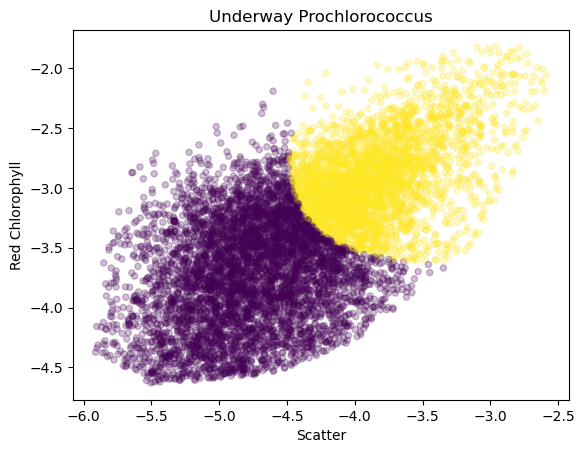

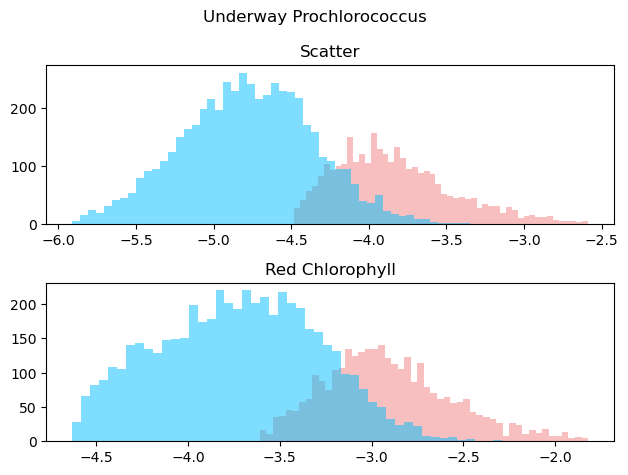

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1975  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1979  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate            Genus Clade  RelAbundance  
1975     -158.0    7.0         A  Prochlorococcus   HLI      0.384488  
1979     -158.0    7.0         A  Prochlorococcus   LLI      0.088318  
[0.81320488 0.18679512]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1218033626.py:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


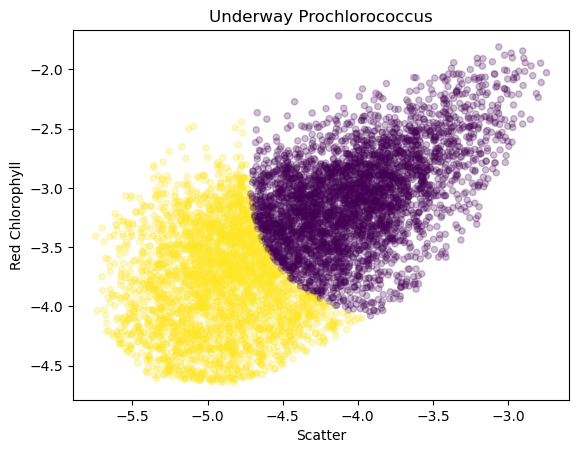

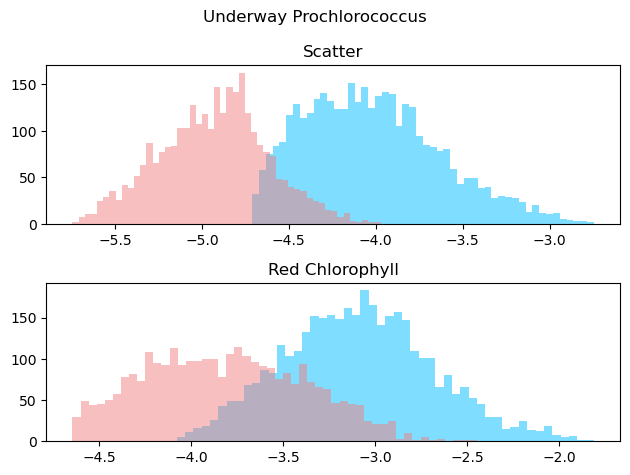

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1975  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1979  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate            Genus Clade  RelAbundance  
1975     -158.0    7.0         A  Prochlorococcus   HLI      0.384488  
1979     -158.0    7.0         A  Prochlorococcus   LLI      0.088318  
[0.81320488 0.18679512]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1218033626.py:16: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


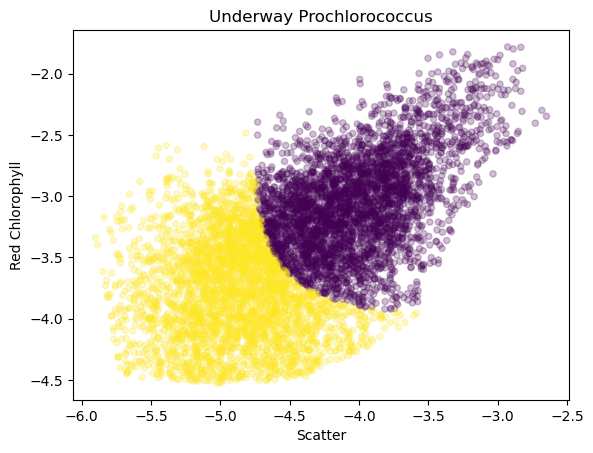

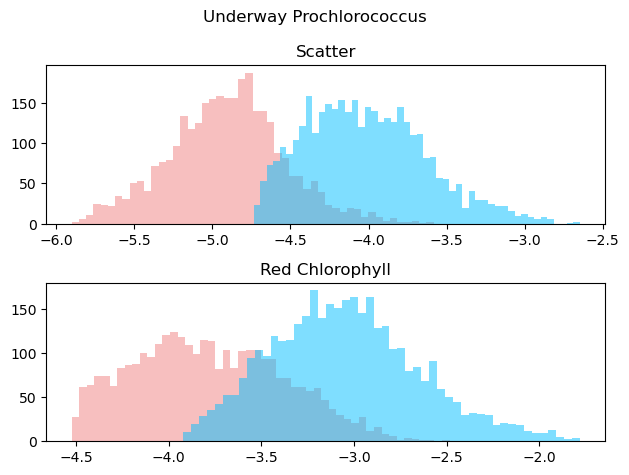

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1975  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1979  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate            Genus Clade  RelAbundance  
1975     -158.0    7.0         A  Prochlorococcus   HLI      0.384488  
1979     -158.0    7.0         A  Prochlorococcus   LLI      0.088318  


In [9]:
# looping through the pro coordinate df 
for pro_underway_coor_index, pro_underway_coor_row in pro_underway_coords.iterrows():
    # obtaining sample ID to find the relative abundance 
    current_sampleid = pro_underway_coor_row['sampleid']
    current_rel_abun_df = g3_ecotype_pro.loc[g3_ecotype_pro['SampleID'] == current_sampleid]
    # obtaining the filename to find data for fcm data
    current_filename = pro_underway_coor_row['filename']
    if (len(current_rel_abun_df['RelAbundance']) >= 2) & (pro_underway_coor_row['list distance'] < 0.05):
        num_clusters = len(current_rel_abun_df['RelAbundance'])
        fcm_df = g3_pro_underway_fcm.loc[g3_pro_underway_fcm['filename'] == current_filename]
        
        # calling into gmm function to obtain the scatter plot and cluster identification
        graph, cluster = gmm_cluster_underway('pro', 3, current_sampleid, current_filename, num_clusters)
        clusters = list(cluster)
        fcm_df.insert(1, 'cluster num', clusters)
        cluster_nums = pd.unique(clusters)

        # creating a plot for histogram grouping of ecotypes
        fig, ax = plt.subplots(nrows=2)
        colors = ['deepskyblue', 'lightcoral', 'violet']
        
        for i in cluster_nums:
            wanted_fcm_cluster = fcm_df.loc[fcm_df['cluster num'] == i]
            ax[0].hist(np.log(wanted_fcm_cluster['norm.scatter']), bins=50, color = colors[i], alpha = 0.5)
            ax[1].hist(np.log(wanted_fcm_cluster['norm.red']), bins=50, color = colors[i], alpha = 0.5)
            
            fig.suptitle('Underway Prochlorococcus')
            ax[0].set_title('Scatter')
            ax[1].set_title('Red Chlorophyll')
        
        #ax.set_ylabel('Count')
        fig.tight_layout()
        plt.show()
        
        print(pro_underway_coor_row['list distance'])
        print(current_rel_abun_df)
    else:
        continue

[0.60232553 0.1170009  0.28067358]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1853101935.py:15: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


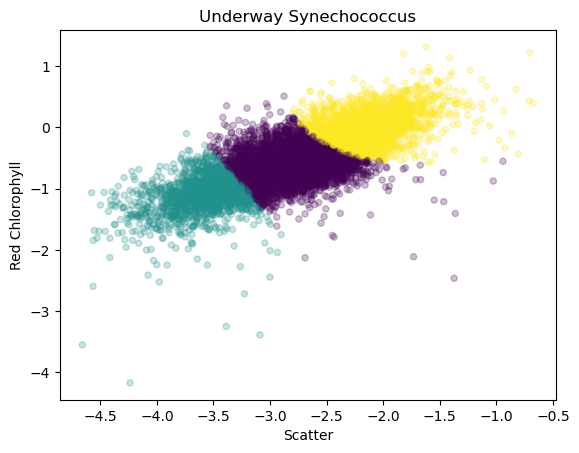

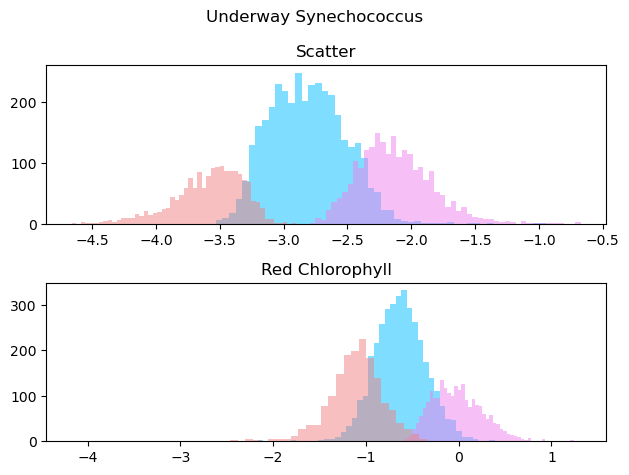

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1988  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1994  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1998  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate          Genus     Clade  RelAbundance  
1988     -158.0    7.0         A  Synechococcus   5.1A-IV      0.273336  
1994     -158.0    7.0         A  Synechococcus  5.1B-VII      0.053095  
1998     -158.0    7.0         A  Synechococcus      CDR2      0.127370  
[0.60232553 0.1170009  0.28067358]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1853101935.py:15: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


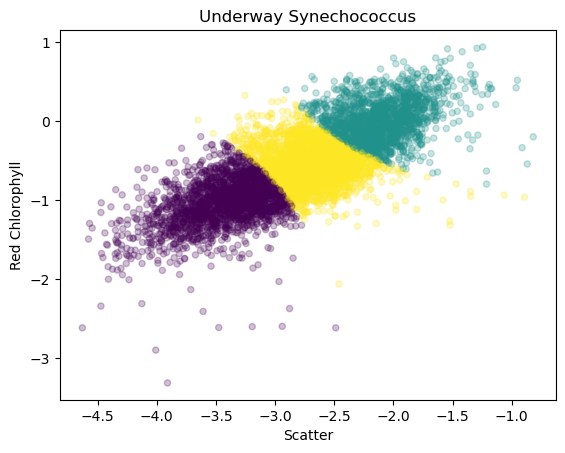

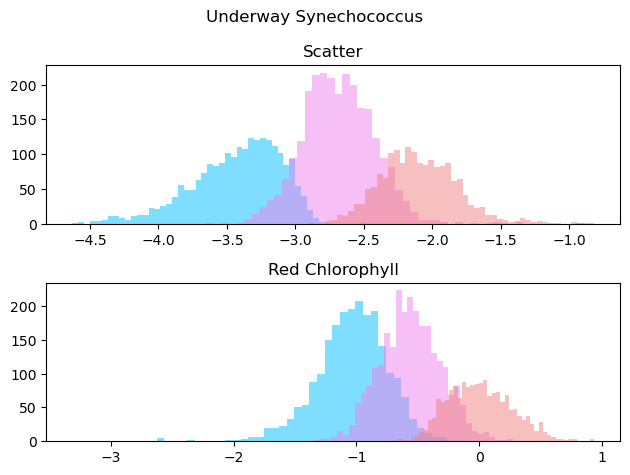

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1988  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1994  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1998  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate          Genus     Clade  RelAbundance  
1988     -158.0    7.0         A  Synechococcus   5.1A-IV      0.273336  
1994     -158.0    7.0         A  Synechococcus  5.1B-VII      0.053095  
1998     -158.0    7.0         A  Synechococcus      CDR2      0.127370  
[0.60232553 0.1170009  0.28067358]


C:\Users\User\AppData\Local\Temp\ipykernel_31420\1853101935.py:15: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  cluster_nums = pd.unique(clusters)


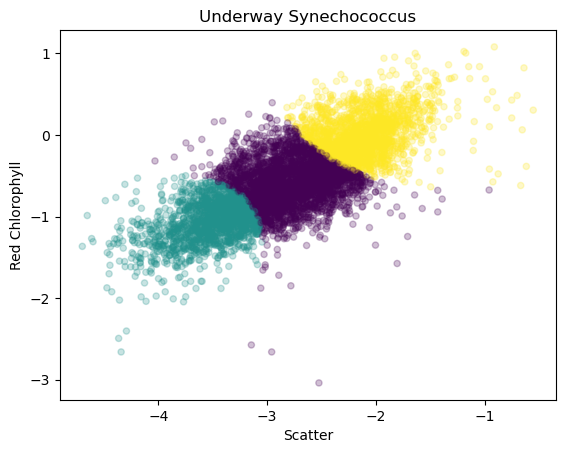

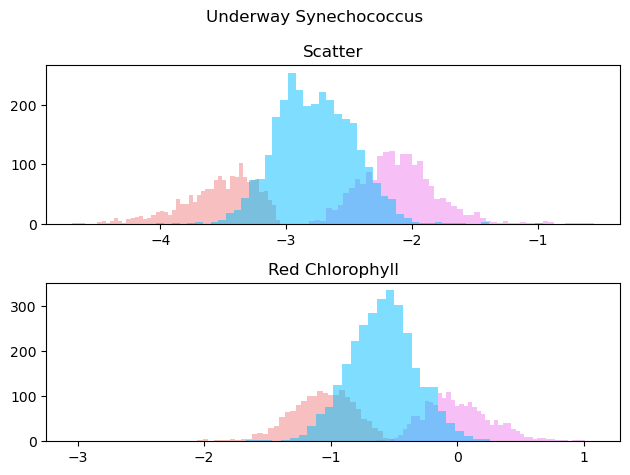

0.04577334231684145
                  SampleID  Cruise  Station           Datetime  Latitude  \
1988  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1994  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   
1998  G3.UW.NS.UW37_1.7m.A  km1906      NaN  04/19/19 18:47:00      37.0   

      Longitude  Depth Replicate          Genus     Clade  RelAbundance  
1988     -158.0    7.0         A  Synechococcus   5.1A-IV      0.273336  
1994     -158.0    7.0         A  Synechococcus  5.1B-VII      0.053095  
1998     -158.0    7.0         A  Synechococcus      CDR2      0.127370  


In [10]:
# looping through the synecho coordinate df 
for syn_underway_coor_index, syn_underway_coor_row in syn_underway_coords.iterrows():
    # obtaining sample ID to find the relative abundance
    current_sampleid = syn_underway_coor_row['sampleid']
    current_rel_abun_df = g3_ecotype_syn.loc[g3_ecotype_syn['SampleID'] == current_sampleid]
    # obtaining the filename to find data for fcm data
    current_filename = syn_underway_coor_row['filename']
    if (len(current_rel_abun_df['RelAbundance']) >= 2) & (syn_underway_coor_row['list distance'] < 0.05):
        num_clusters = len(current_rel_abun_df['RelAbundance'])
        fcm_df = g3_syn_underway_fcm.loc[g3_syn_underway_fcm['filename'] == current_filename]
        
        graph, cluster = gmm_cluster_underway('syn', 3, current_sampleid, current_filename, num_clusters)
        clusters = list(cluster)
        fcm_df.insert(1, 'cluster num', clusters)
        cluster_nums = pd.unique(clusters)

        fig, ax = plt.subplots(nrows=2)
        colors = ['deepskyblue', 'lightcoral', 'violet']
        
        for i in cluster_nums:
            wanted_fcm_cluster = fcm_df.loc[fcm_df['cluster num'] == i]
            ax[0].hist(np.log(wanted_fcm_cluster['norm.scatter']), bins=50, color = colors[i], alpha = 0.5)
            ax[1].hist(np.log(wanted_fcm_cluster['norm.red']), bins=50, color = colors[i], alpha = 0.5)
            
            fig.suptitle('Underway Synechococcus')
            ax[0].set_title('Scatter')
            ax[1].set_title('Red Chlorophyll')
        
        #ax.set_ylabel('Count')
        fig.tight_layout()
        plt.show()
        
        print(syn_underway_coor_row['list distance'])
        print(current_rel_abun_df)
    
    else:
        continue